In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import agentpy as ap
from matplotlib import colors

In [2]:
from datetime import datetime

# file to store outputs, in sequential order for now
file = open("log_prelim.txt", "a+")


# basic square forest
# each cell has 3 possible states: 0, 1, 2 corresponding to empty, tree, fire

# this class is not done, I keep adding properties after testing them out individually
class square_forest:
	# ideally evolves till full destruction, but we can set a hard limit on time

	def __init__(self):
		self.dim = int(input("\nEnter dimension of your square forest: "))
		self.cells = np.zeros((self.dim, self.dim))
		print(f"\npre-init of forest grid \n{self.cells}\n")
		self.burnt = [] # not really a property, just easier to not pass this hehe

	
	# def set_dim(self):
	# 	self.dim = int(input("\nEnter dimension of your square forest: "))
	
	
	def init_cells(self):
		# random init with some number of trees; upper limit = dim * dim
		n_max = np.random.randint(self.dim * self.dim) 

		loc_trees = set()
		for i in range(n_max):
			coords = tuple(np.random.randint(self.dim, size=2))
			loc_trees.add(coords)
			
		
		for tree in loc_trees:
			# note here that the actual no. of trees in the init config is <= n_trees since the guessed locations need not be unique
			self.cells[tree[0], tree[1]] = 1

		print(f"\nafter random tree planting: \n{self.cells}")
	
#-------------------------------------------------------------------------------

In [3]:
def init_forest(dim):	
	"""Create a forest as a grid of dim x dim size. 
    
    Input:
    dim (int): dimension of the forest grid.
    
    Output:
    dim x dim forest grid with randomly planted trees."""
    
	forest = np.zeros((dim, dim))
	n_trees = np.random.randint(dim * dim)

	loc_trees = set()
	for i in range(n_trees):
		coords = np.random.randint(dim, size=2)
		loc_trees.add(tuple(coords))
		
	
	for tree in loc_trees:
		forest[tree[0], tree[1]] = 1

	print("\n Here is the initial forest config:\n", forest)
	return forest


In [4]:
def get_valid_neighbours(cell, forest, dim):
	print("\nEntered get_valid_neighbours()")
	
	row, col = cell[0], cell[1]
	if row < 0 : 
		raise Exception("negative row index encountered")

	elif col < 0 : 
		raise Exception("negative column index encountered")

	elif row >= dim : 
		raise Exception("row index out of dimension bounds")

	elif col >= dim : 
		raise Exception("column index out of dimension bounds")

	else:

		neighbours = [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
		print("\n -- adjacent cells indices are: ", neighbours)


		for i, (r, c) in enumerate(neighbours):
			if r < 0 or c < 0 or r == dim or c == dim:
				neighbours[i] = None
			elif forest[r, c] != 1 :
				neighbours[i] = None

		print("\n -- after None-ifying non tree cells and invalid edge cases: ", neighbours)

		valid_neighbours = []
		for n in neighbours:
			if n != None:
				valid_neighbours.append(n)

		print("\n Final valid list: ", valid_neighbours)
		return valid_neighbours


In [5]:
def pick_fire_location(dim):
	return np.random.randint(dim, size=2)


In [6]:
def spread_to(valid_neighbours, forest, dim, burnt):

	print("\n---------------------------\nThe next degree neighbours are at: ", valid_neighbours)
	
	# now we burn all of them:
	for (row, col) in valid_neighbours:
		# decimate: first set to 2
		forest[row, col] = 2
		burnt.append((row, col))
	print("\n incendio \n", forest)

	# spread to second degree neighbours
	for cell in valid_neighbours:
		next_neighbours = get_valid_neighbours(cell, forest, dim)
		if len(next_neighbours) != 0: # i.e has somewhere to spread to
			spread_to(next_neighbours, forest, dim, burnt)

	print("\n----------DONE RECURSING---------")

In [7]:
def simulate_one_fire(dim):
	'''
	at the moment, this inits the forest, but ideally, it should inherit a forest instance where multiple fires can occur following the frequency parameter

	collects/returns area information as a diagnostic, should put it into a file with simulation number and details of the simulation
	'''
	forest = init_forest(dim)
	file.write(f"\nEntry time: {datetime.now()}\nInitial config: {forest}")
	
	fire_at = pick_fire_location(dim)
	file.write(f"\nFire started at: {fire_at}")
	burnt = []

	# 0 means empty cell, 1 means cell has a tree
	forest[fire_at[0], fire_at[1]] = 2 
	print(f"\n fire started at {fire_at}: \n", forest)
	burnt.append(fire_at)	

	# start and spread
	neighbours = get_valid_neighbours(fire_at, forest, dim)
	spread_to(neighbours, forest, dim, burnt)

	# go to all burnt sites and set them to 0 at the end of one spread.
	for (r, c) in burnt:
		forest[r, c] = 0

	print("\n After the damage:\n ", forest)
	area_burnt = len(burnt) # in cells; assuming one cell == one square unit of area
	# print(f"\nArea burnt in this fire: {area_burnt} sq. units.\n")

	return area_burnt

In [8]:
def plant_tree(forest):

    while True:
        coords = np.random.randint(forest.shape[0], size=2)
        if forest[coords[0], coords[1]] == 1:
            continue
        else:
            forest[coords[0], coords[1]] = 1
            break

    return forest

In [9]:
#dim = int(input("\nEnter the dimension of the forest you want to simulate: "))
#damage = simulate_one_fire(dim)

In [10]:
def grid_collector(param):
    grid_coll = []
    if param=="slow":
        grid_coll = grid_coll.append(self.cells)

### Function to plant a tree 

In [11]:
def plant_tree(forest):

    while True:
        coords = np.random.randint(forest.shape[0], size=2)
        if forest[coords[0], coords[1]] == 1:
            continue
        else:
            forest[coords[0], coords[1]] = 1
            break

    return forest


 Here is the initial forest config:
 [[0. 1. 1. 0. 1.]
 [0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1.]]


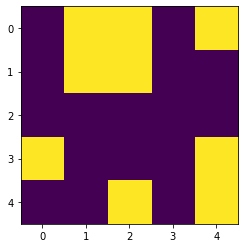

In [69]:
forest = init_forest(5)
plt.imshow(forest)

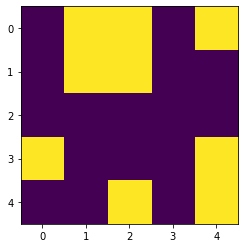

In [70]:
grid_collector = []
grid_collector.append(forest)

plt.imshow(grid_collector[0])

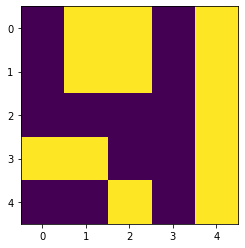

In [76]:
plt.imshow(grid_collector[3])

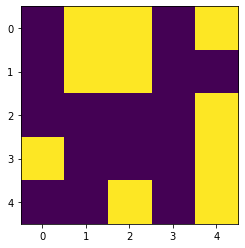

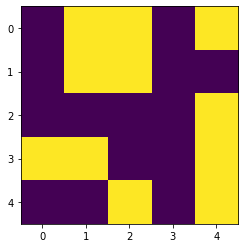

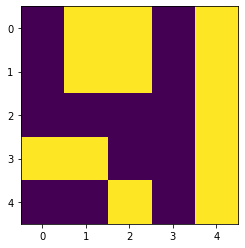

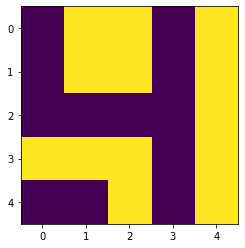

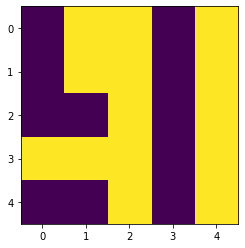

In [71]:
color_dict = {0:'wheat', 1:'yellowgreen', 2:'darkorange'}

for i in range(5):
    plant_tree(forest)
    plt.imshow(forest)
    plt.show()
    grid_collector.append(forest.copy())


[[0. 1. 1. 0. 1.]
 [0. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1.]]


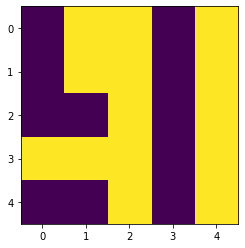

[[0. 1. 1. 0. 1.]
 [0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1.]]


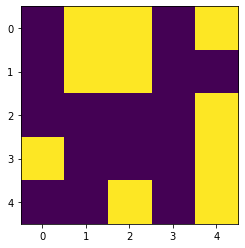

[[0. 1. 1. 0. 1.]
 [0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1.]]


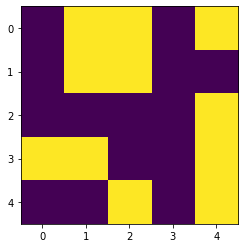

[[0. 1. 1. 0. 1.]
 [0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1.]]


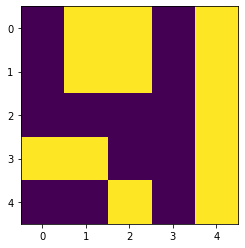

[[0. 1. 1. 0. 1.]
 [0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1.]]


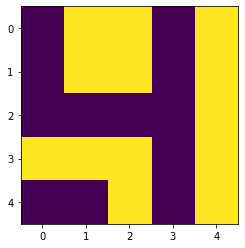

[[0. 1. 1. 0. 1.]
 [0. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1.]]


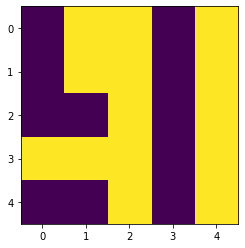

In [80]:
## for some reason it takes only the final forest, not each iteration
## why even grid_collector[0] is overwritten by the final state?

for i in grid_collector:
    print(i)
    plt.imshow(i)
    plt.show()

In [17]:
color_dict = {0:'wheat', 1:'yellowgreen', 2:'darkorange'}
#fix, ax = plt.subplot()
for i in range(1, 15):
    plant_tree(forest)
    pick_fire_location(forest.shape)
    print(forest)
    #fig, ax = plt.subplot()
    #ap.gridplot(forest, ax=ax, color_dict=color_dict, convert=True)
    grid_collector.append(forest)

[[1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 0.]
 [1. 1. 0. 1. 1.]
 [0. 1. 1. 0. 0.]]
[[1. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 0.]
 [1. 1. 0. 1. 1.]
 [0. 1. 1. 0. 0.]]
[[1. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 0.]
 [1. 1. 0. 1. 1.]
 [0. 1. 1. 1. 0.]]
[[1. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1.]
 [0. 1. 1. 1. 0.]]
[[1. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1.]
 [0. 1. 1. 1. 0.]]
[[1. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1.]
 [0. 1. 1. 1. 0.]]
[[1. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 0.]]
[[1. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1.]]
[[1. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
[[1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
[[1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]

KeyboardInterrupt: 

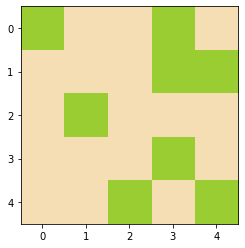

In [14]:
fig, ax = plt.subplots()
#plt.figure(figsize=(6,6))
color_dict = {0:'wheat', 1:'yellowgreen', 2:'darkorange'}
ap.gridplot(forest, ax=ax, color_dict=color_dict, convert=True)
